# Microbusiness density forecasting

American policy leaders strive to develop economies that are more inclusive and resilient to downturns. They're also aware that with advances in technology, entrepreneurship has never been more accessible than it is today. Whether to create a more appropriate work/life balance, to follow a passion, or due to loss of employment, studies have demonstrated that Americans increasingly choose to create businesses of their own to meet their financial goals. The challenge is that these "microbusinesses" are often too small or too new to show up in traditional economic data sources, making it nearly impossible for policymakers to study them. But data science could help fill in the gaps and provide insights into the factors associated these businesses.

In this project I will try to evaluate and compare several regression models that will predict those values using machine learning tools. It is based on kaggle competition - [GoDaddy - Microbusiness Density Forecasting](https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/overview).

<img src="img/img1.jpg" alt="Happy enterpreneur" title="Just look at how happy he is" />

Let's begin with imports and initial commands:

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import linear_model

pd.set_option('mode.chained_assignment', None) # Turn off SettingWithCopyWarning

## Data gathering
First, let's import data provided by the competition organizers that we will use. Datasets that will be imported:

- train_set - this contains information regarding each county and target variable for training:
    - row_id - An ID code for the row,
    - cfips - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county,
    - county_name - The written name of the county,
    - state_name - The name of the state,
    - first_day_of_month - The date of the first day of the month
    - microbusiness_density - Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.,
    - active - The raw count of microbusinesses in the county. Not provided for the test set.
- revealed_test - Set of revealed values for the most recent months available. I will use it to test my results.
- sample_submission - This set contains rows that must br predicted to take part in the competition.


In [2]:
train_set = pd.read_csv('data/train.csv')
train_set.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269


In [3]:
revealed_test = pd.read_csv('data/revealed_test.csv')
revealed_test.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2022-11-01,1001,Autauga County,Alabama,2022-11-01,3.442677,1463
1,1001_2022-12-01,1001,Autauga County,Alabama,2022-12-01,3.470915,1475
2,1003_2022-11-01,1003,Baldwin County,Alabama,2022-11-01,8.257636,14145


In [4]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.head(3)

,row_id,microbusiness_density
0,1001_2022-11-01,3.817671
1,1003_2022-11-01,3.817671
2,1005_2022-11-01,3.817671


Next I am reading files found at website of [Bureau of Labor Statistics](https://www.bls.gov/home.htm), which contain:

- manufacturing_employment_data - number of people employed in manufacturing - in thousands
- private_employment_data - number of people employed in private firms - in thousands
- public_employment_data - number of people employed in public institutions - in thousands
- retail_employment_data - number of people employed in retail sector - in thousands
- total_employment_data - total number of people employed - in thousands
- unemployment_rate_data - unemployment rate

This data will be used in fitting our models.

In [5]:
# Create DF with additional data from csv files, containing several indicators for each state per month.
manufacturing_employment_data = pd.read_csv('data/all_indicators-all_data/manufacturing_employment_raw_in_thousands.csv')
private_employment_data = pd.read_csv('data/all_indicators-all_data/private_employment_raw_in_thousands.csv')
public_employment_data = pd.read_csv('data/all_indicators-all_data/public_employment_raw_in_thousands.csv')
retail_employment_data = pd.read_csv('data/all_indicators-all_data/retail_trade_employment_raw_in_thousands.csv')
total_employment_data = pd.read_csv('data/all_indicators-all_data/total_employment_raw_in_thousands.csv')
unemployment_rate_data = pd.read_csv('data/all_indicators-all_data/unemployment_rate_raw.csv')

# Sample head:
manufacturing_employment_data.head()

,Geography,1990-01-01,1990-02-01,1990-03-01,1990-04-01,1990-05-01,1990-06-01,1990-07-01,1990-08-01,1990-09-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
0,United States,17797.0,17893.0,17868.0,17845.0,17797.0,17776.0,17704.0,17649.0,17609.0,...,12689.0,12750.0,12769.0,12794.0,12831.0,12867.0,12884.0,12918.0,12926.0,12934.0
1,Alabama,365.5,362.5,360.6,366.6,366.2,367.5,364.6,364.7,364.9,...,266.6,267.9,268.3,268.8,268.4,268.3,270.6,271.7,272.1,272.7
2,Alaska,12.4,12.4,12.9,13.7,14.5,14.5,14.3,14.4,14.0,...,11.1,11.6,11.4,10.8,10.8,11.0,11.0,11.2,11.3,11.1
3,Arizona,177.3,177.6,177.1,176.5,176.7,176.8,177.2,176.8,176.1,...,186.1,189.5,189.3,190.8,193.1,194.7,196.9,197.6,197.6,198.4
4,Arkansas,218.4,218.9,217.8,219.0,219.2,219.9,219.8,220.2,221.1,...,162.2,162.7,162.9,163.2,164.4,164.9,165.1,165.0,164.2,164.4


## Exploratory data analysis

TODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODO
Put here lag feature

## Feature engineering

### Datasets manipulation

I want to gather data read in previous step in one DataFrame. To do it I must reshape the DataFrames:

In [6]:
# Reshape datasets
manufacturing_employment_data_reshaped = manufacturing_employment_data.melt(
    id_vars=['Geography'], var_name='first_day_of_month',  value_name='manufacturing_employment')
private_employment_data_reshaped = private_employment_data.melt(
    id_vars=['Geography'], var_name='first_day_of_month',  value_name='private_employment')
public_employment_data_reshaped = public_employment_data.melt(
    id_vars=['Geography'], var_name='first_day_of_month',  value_name='public_employment')
retail_employment_data_reshaped = retail_employment_data.melt(
    id_vars=['Geography'], var_name='first_day_of_month',  value_name='retail_employment')
total_employment_data_reshaped = total_employment_data.melt(
    id_vars=['Geography'], var_name='first_day_of_month',  value_name='total_employment')
unemployment_rate_data_reshaped = unemployment_rate_data.melt(
    id_vars=['Geography'], var_name='first_day_of_month',  value_name='unemployment_rate')

# Sample head
public_employment_data_reshaped.head(3)

,Geography,first_day_of_month,public_employment
0,United States,1990-01-01,18151.0
1,Alabama,1990-01-01,325.4
2,Alaska,1990-01-01,68.8


Next, I am merging all of them to one big DataFrame

In [7]:
# Create gathered data DataFrame
gathered_data_df = pd.merge(
    manufacturing_employment_data_reshaped,
    private_employment_data_reshaped,
    how='left',
    left_on=['Geography', 'first_day_of_month'],
    right_on=['Geography', 'first_day_of_month']
)

gathered_data_df = pd.merge(
    gathered_data_df,
    public_employment_data_reshaped,
    how='outer',
    left_on=['Geography', 'first_day_of_month'],
    right_on=['Geography', 'first_day_of_month']
)

gathered_data_df = pd.merge(
    gathered_data_df,
    retail_employment_data_reshaped,
    how='outer',
    left_on=['Geography', 'first_day_of_month'],
    right_on=['Geography', 'first_day_of_month']
)

gathered_data_df = pd.merge(
    gathered_data_df,
    total_employment_data_reshaped,
    how='outer',
    left_on=['Geography', 'first_day_of_month'],
    right_on=['Geography', 'first_day_of_month']
)

gathered_data_df = pd.merge(
    gathered_data_df,
    unemployment_rate_data_reshaped,
    how='outer',
    left_on=['Geography', 'first_day_of_month'],
    right_on=['Geography', 'first_day_of_month']
)

# Change column name just for convenience and easier future merging
gathered_data_df = gathered_data_df.rename(columns={'Geography': 'state'})

gathered_data_df.head(3)

,state,first_day_of_month,manufacturing_employment,private_employment,public_employment,retail_employment,total_employment,unemployment_rate
0,United States,1990-01-01,17797.0,91048.0,18151.0,13260.2,109199.0,5.4
1,Alabama,1990-01-01,365.5,1310.5,325.4,191.2,1635.9,6.7
2,Alaska,1990-01-01,12.4,162.0,68.8,25.3,230.8,7.2


I will also add column of first day of month given in ordinal value, so that we can use it as regression variable.

In [8]:
# Add First day of month ordinal value
gathered_data_df['first_day_of_month_ordinal'] = pd.to_datetime(gathered_data_df['first_day_of_month'])
gathered_data_df['first_day_of_month_ordinal'] = [datetime.datetime.toordinal(x) for x in
                                                  gathered_data_df['first_day_of_month_ordinal']]
gathered_data_df.head(3)

,state,first_day_of_month,manufacturing_employment,private_employment,public_employment,retail_employment,total_employment,unemployment_rate,first_day_of_month_ordinal
0,United States,1990-01-01,17797.0,91048.0,18151.0,13260.2,109199.0,5.4,726468
1,Alabama,1990-01-01,365.5,1310.5,325.4,191.2,1635.9,6.7,726468
2,Alaska,1990-01-01,12.4,162.0,68.8,25.3,230.8,7.2,726468


### Training and test sets

In the next step I am preparing sets used for training and testing models. Those will be divided into two cases:

- Data for all counties - this will let us validate our models,
- Data for one county - this will make it easier to show on a plot how regression acts.


First I will specify columns that contain pure values that can be used as training parameters

In [9]:
value_columns = ['manufacturing_employment', 'private_employment', 'public_employment', 'retail_employment',
                 'total_employment', 'unemployment_rate', 'first_day_of_month_ordinal']

And now we can specify our training and test sets. I will create all_train and all_test DataFrames with additional values like cfips or first_day_of_month to extract some specific rows if needed. Train data will base on train_set and test data will base on revealed_test, which is the latest data published.
**My assumption for prediction strategy -** I treat this project educational and my main goal for this project is to learn machine learning techniques, so I am looking for relationships between data from the same month. I think some factors may have lagged impact on microbusiness density, but in this project I will neglect it intentionally, not to make the notebook too vast.

Let's start with values for whole country:

In [10]:
# Training data for all regions
all_train = pd.merge(
    train_set,
    gathered_data_df,
    how='left',
    left_on=['state', 'first_day_of_month'],
    right_on=['state', 'first_day_of_month']
)

all_train.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,manufacturing_employment,private_employment,public_employment,retail_employment,total_employment,unemployment_rate,first_day_of_month_ordinal
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,268.7,1689.2,394.0,230.3,2083.2,2.9,737272
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,268.4,1688.7,394.0,230.5,2082.7,2.9,737303
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,268.8,1688.0,393.1,230.5,2081.1,3.0,737333


In [11]:
# Training set for all regions - variables
all_train_X = all_train.loc[:, value_columns]
all_train_X.head(3)

,manufacturing_employment,private_employment,public_employment,retail_employment,total_employment,unemployment_rate,first_day_of_month_ordinal
0,268.7,1689.2,394.0,230.3,2083.2,2.9,737272
1,268.4,1688.7,394.0,230.5,2082.7,2.9,737303
2,268.8,1688.0,393.1,230.5,2081.1,3.0,737333


In [12]:
# Training set for all regions - target values
all_train_y = all_train.loc[:, 'microbusiness_density']
all_train_y.head(3)

0    3.007682
1    2.884870
2    3.055843
Name: microbusiness_density, dtype: float64

In [13]:
# Testing data for all regions
all_test = pd.merge(
    revealed_test,
    gathered_data_df,
    how='left',
    on=['state', 'first_day_of_month']
)

all_test.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,manufacturing_employment,private_employment,public_employment,retail_employment,total_employment,unemployment_rate,first_day_of_month_ordinal
0,1001_2022-11-01,1001,Autauga County,Alabama,2022-11-01,3.442677,1463,272.1,1710.6,393.3,237.3,2103.9,2.7,738460
1,1001_2022-12-01,1001,Autauga County,Alabama,2022-12-01,3.470915,1475,272.7,1713.1,395.3,238.0,2108.4,2.8,738490
2,1003_2022-11-01,1003,Baldwin County,Alabama,2022-11-01,8.257636,14145,272.1,1710.6,393.3,237.3,2103.9,2.7,738460


In [14]:
# Testing data - variables
all_test_X = all_test.loc[:, value_columns]
all_test_X.head(3)

,manufacturing_employment,private_employment,public_employment,retail_employment,total_employment,unemployment_rate,first_day_of_month_ordinal
0,272.1,1710.6,393.3,237.3,2103.9,2.7,738460
1,272.7,1713.1,395.3,238.0,2108.4,2.8,738490
2,272.1,1710.6,393.3,237.3,2103.9,2.7,738460


In [30]:
# Testing data - validation values
all_test_y = all_test.loc[:, ['cfips', 'first_day_of_month', 'microbusiness_density']]
all_test_y.head(3)

,cfips,first_day_of_month,microbusiness_density
0,1001,2022-11-01,3.442677
1,1001,2022-12-01,3.470915
2,1003,2022-11-01,8.257636


Now let's get one specific county and extract values just for it, to have a look on a plot how particular models work.

In [16]:
# Select county
cfips = 1005

# Training sets
single_train_X = all_train.loc[all_train['cfips']==cfips, value_columns]
single_train_y = all_train.loc[all_train['cfips']==cfips, 'microbusiness_density']
single_train_X.head()

,manufacturing_employment,private_employment,public_employment,retail_employment,total_employment,unemployment_rate,first_day_of_month_ordinal
78,268.7,1689.2,394.0,230.3,2083.2,2.9,737272
79,268.4,1688.7,394.0,230.5,2082.7,2.9,737303
80,268.8,1688.0,393.1,230.5,2081.1,3.0,737333
81,269.0,1690.3,393.2,230.5,2083.5,3.1,737364
82,269.3,1691.4,393.0,229.8,2084.4,3.2,737394


In [17]:
# Testing sets
single_test_X = all_test.loc[all_test['cfips']==cfips, value_columns]
single_test_y = all_test.loc[all_test['cfips']==cfips, 'microbusiness_density']
single_test_y.head()

4    1.247223
5    1.252272
Name: microbusiness_density, dtype: float64

As can be seen above, there are just two rows, because in revealed_test there are values from only two months available.

At the end of this part I will create a template of DataFrame to store prediction values for single county

In [18]:
single_prediction_results_template = all_train.loc[all_train['cfips']==cfips, ['first_day_of_month', 'microbusiness_density']]
single_prediction_results_template.head(3)

,first_day_of_month,microbusiness_density
78,2019-08-01,1.073138
79,2019-09-01,0.995794
80,2019-10-01,1.160149


## Data analysis

Let's start analyzing data with defining function that will score our models. We will use Symmetric mean absolute percentage error, which is an accuracy measure based on relative errors. It is defined as follows:
<br />

$$
\large SMAPE = \frac{1}{n} \sum_{t=1}^{n} \frac {|F_t - A_t|} { \frac {(|F_t| + |A_t|)} {2} }
$$

Where:
- $F_t$ - predicted value
- $A_t$ - actual value


In [19]:
# Validation function
def smape(actual, forecast):
    numerator = np.abs(actual-forecast)
    denominator = (np.abs(actual) + np.abs(forecast))/2
    return 1/len(actual) * np.sum(numerator/denominator)

### Linear regression model - ordinary least squares

I will start with the most basic type of regression - ordinary least squares. I will train model for data of each cfips number and store predicted value that will be compared to test set.

In [56]:
# Create model
lin_reg_model = linear_model.LinearRegression()

### Ridge regression

In [ ]:
# Create model
ridge_alphas = np.logspace(-5, 5, 11)
ridge_model = linear_model.RidgeCV(alphas=ridge_alphas)

### Lasso

In [76]:
# Create models
lasso_alphas = np.logspace(-5, 5, 11)
lasso_model = linear_model.LassoLarsCV()

### Storing values
Let's prepare a DataFrames to store predicted values

In [77]:
predicted_values_list = ['cfips', 'first_day_of_month', 'lin_reg_prediction', 'ridge_prediction', 'lasso_prediction']
predicted_values_df = pd.DataFrame(columns=predicted_values_list)

### Predicting
Now the main part: we will iterate through our training data and train models for each county

In [79]:
# For each day of each cfips we will prepare dataframe with results with following columns:

for iter_cfips in all_train['cfips'].unique():
    # Get training data
    iter_train_X = all_train.loc[all_train['cfips']==iter_cfips, value_columns]
    iter_train_y = all_train.loc[all_train['cfips']==iter_cfips, 'microbusiness_density']
    # Fit models
    lin_reg_model.fit(iter_train_X, iter_train_y)
    ridge_model.fit(iter_train_X, iter_train_y)
    lasso_model.fit(iter_train_X, iter_train_y)
    # Get test data and predict on it
    iter_test_X = all_test.loc[all_test['cfips']==iter_cfips, value_columns]
    lin_reg_y = lin_reg_model.predict(iter_test_X)
    ridge_y = ridge_model.predict(iter_test_X)
    lasso_y = lasso_model.predict(iter_test_X)
    # Store data
    days_predicted = all_test.loc[all_train['cfips']==iter_cfips, 'first_day_of_month'].unique()
    for day_index, iter_day in enumerate(days_predicted):
        results_list = [
            iter_cfips, # cfips
            iter_day, # first_day_of_month
            lin_reg_y[day_index], # lin_reg_prediction
            ridge_y[day_index], # ridge_prediction
            lasso_y[day_index] # lasso_prediction
        ]
        iter_results_df = pd.DataFrame(data=[results_list], columns=predicted_values_list)
        predicted_values_df = pd.concat([predicted_values_df, iter_results_df])

    predicted_values_df.head(3)

Let's compare the results. I will create a DataFrame to keep target value for revealed_test and predicted values

In [80]:
model_comparison_df = pd.merge(
    all_test_y.copy(),
    predicted_values_df,
    how='left',
    on=['cfips', 'first_day_of_month']
)
model_comparison_df.head(3)

,cfips,first_day_of_month,microbusiness_density,lin_reg_prediction,ridge_prediction,lasso_prediction
0,1001,2022-11-01,3.442677,3.441722,3.424219,3.425319
1,1001,2022-12-01,3.470915,3.480276,3.445445,3.438163
2,1003,2022-11-01,8.257636,8.415975,8.342122,8.363835


In [82]:
print(f'SMAPE score for LinearRegression: '
      f'{smape(model_comparison_df["microbusiness_density"], model_comparison_df["lin_reg_prediction"]): .5f}')
print(f'SMAPE score for RidgeRegression: '
      f'{smape(model_comparison_df["microbusiness_density"], model_comparison_df["ridge_prediction"]): .5f}')
print(f'SMAPE score for LassoLarsCV regression: '
      f'{smape(model_comparison_df["microbusiness_density"], model_comparison_df["lasso_prediction"]): .5f}')

SMAPE score for LinearRegression:  0.00231
SMAPE score for RidgeRegression:  0.00242
SMAPE score for LassoLarsCV regression:  0.00352


### Models comparison for single county
Now let's check how those models work for single county

In [83]:
# Fit models with training data
lin_reg_model.fit(single_train_X, single_train_y)
ridge_model.fit(single_train_X, single_train_y)
# Predict values for test set
single_lin_reg_y = lin_reg_model.predict(single_train_X)
single_ridge_y = ridge_model.predict(single_train_X)
single_lasso_y = lasso_model.predict(single_train_X)
# Calculate SMAPE for training data to check how well our model suits it
SMAPE_lin_reg_single = smape(single_lin_reg_y, single_train_y)
SMAPE_ridge_single = smape(single_ridge_y, single_train_y)
SMAPE_lasso_single = smape(single_ridge_y, single_train_y)
# Create DF to store results and for plot
single_prediction_results = single_prediction_results_template.copy()
single_prediction_results['linear_regression_prediciton'] = single_lin_reg_y
single_prediction_results['ridge_prediciton'] = single_ridge_y
single_prediction_results['lasso_prediciton'] = single_lasso_y
single_prediction_results.head(3)

,first_day_of_month,microbusiness_density,linear_regression_prediciton,ridge_prediciton,lasso_prediciton
78,2019-08-01,1.073138,1.034871,1.024547,-0.019391
79,2019-09-01,0.995794,1.047396,1.033759,-0.013973
80,2019-10-01,1.160149,1.034553,1.029192,0.005755


In [84]:
# Reshape DF for plot
single_lin_reg_results_plot = single_prediction_results.melt(
    id_vars='first_day_of_month',
    var_name='status'
)
single_lin_reg_results_plot.head(3)

,first_day_of_month,status,value
0,2019-08-01,microbusiness_density,1.073138
1,2019-09-01,microbusiness_density,0.995794
2,2019-10-01,microbusiness_density,1.160149


Let's show it on a plot!

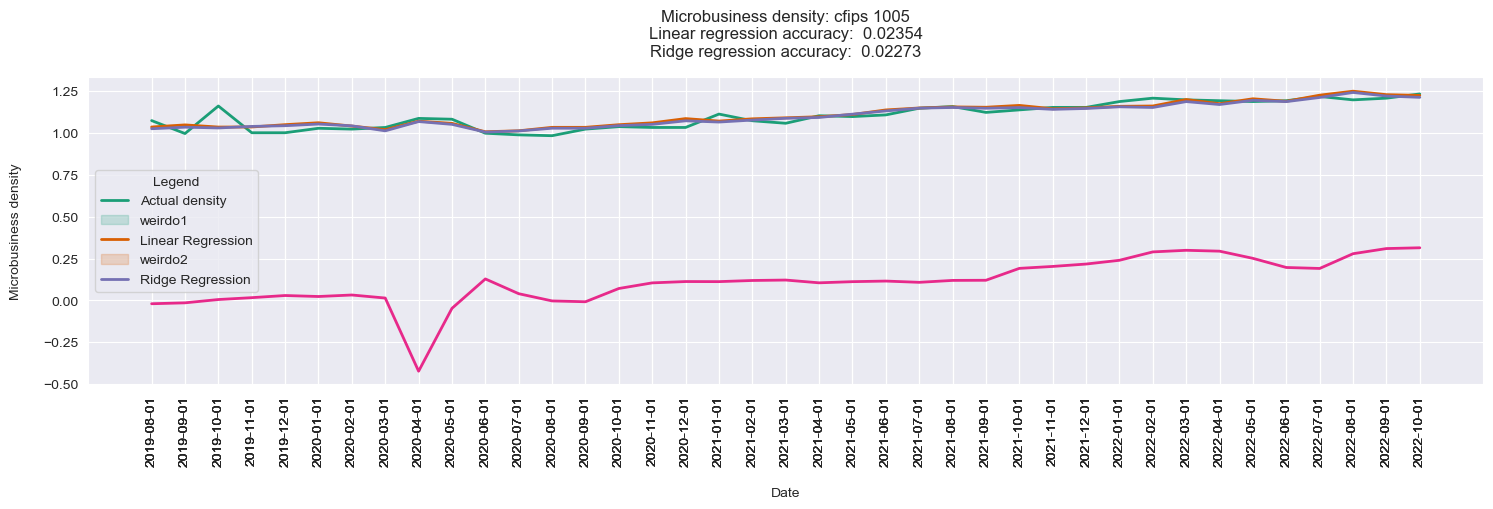

In [85]:
# Plot
fig, ax = plt.subplots(figsize=(18, 4), squeeze=False)

ax = sns.lineplot(
    data=single_lin_reg_results_plot,
    x='first_day_of_month',
    y='value',
    hue='status',
    linewidth=2,
    palette='Dark2' # ['firebrick', 'cornflowerblue', 'darkorange']
)

ax.set_title(f'Microbusiness density: cfips {cfips}\n'
             f'Linear regression accuracy: {SMAPE_lin_reg_single: .5f}\n'
             f'Ridge regression accuracy: {SMAPE_ridge_single: .5f}', pad=15)
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Microbusiness density', labelpad=15)
ax.tick_params(axis='x', rotation=90)
ax.set_xticks(single_lin_reg_results_plot['first_day_of_month'])
plt.legend(title='Legend', labels=['Actual density', 'weirdo1', 'Linear Regression', 'weirdo2', 'Ridge Regression'])

plt.show()

-----
-----
-----

NameError: name 'y_pred_lag_df' is not defined

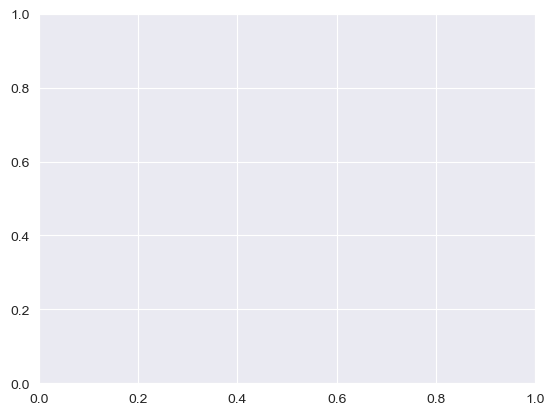

In [27]:
# Plot lag data
fig, ax = plt.subplots(squeeze=False)

sns.lineplot(
    data=y_pred_lag_df,
    x='microbusiness_density_lag',
    y='predicted',
    color='firebrick',
    ax=ax[0, 0]
)

sns.scatterplot(
    data=lin_reg_lag_df,
    x='microbusiness_density_lag',
    y='microbusiness_density',
    ax=ax[0, 0]
)
ax[0, 0].set_title('Lag feature microbusiness density plot', pad=15)
ax[0, 0].set_xlabel('Previous month density', labelpad=15)
ax[0, 0].set_ylabel('Current month density', labelpad=15)

plt.show()

**Conclusion:** From above we can see a strong relation between previous and current month data

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(18, 4), squeeze=False)

sns.lineplot(
    data=y_pred_lag_df,
    x='first_day_of_month',
    y='predicted',
    ax=ax[0, 0],
    color='firebrick',
    linewidth=3
)

sns.lineplot(
    data=lin_reg_lag_df,
    x='first_day_of_month',
    y='microbusiness_density',
    ax=ax[0, 0]
)
ax[0, 0].set_title(f'Microbusiness density: cfips {cfips}', pad=15)
ax[0, 0].set_xlabel('Date', labelpad=15)
ax[0, 0].set_ylabel('Microbusiness density', labelpad=15)
ax[0, 0].tick_params(axis='x', rotation=90)
ax[0, 0].set_xticks(y_pred_lag_df['first_day_of_month'])

plt.show()

**Conclusion:** even though the system looks more responsive to data changes, it gave worse SMAPE result.

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(18, 4))
ax = sns.lineplot(
    data=ridge_single_forecast_plot_df,
    x='first_day_of_month',
    y='density',
    hue='status',
    linewidth=2,
    palette=['firebrick', 'cornflowerblue']
)

ax.set_title(f'Microbusiness density: cfips {cfips}', pad=15)
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Microbusiness density', labelpad=15)
ax.tick_params(axis='x', rotation=90)
plt.legend(title='Legend', labels=['Predicted', 'Some weird rectangle idk tbh', 'Actual'])

plt.show()